# PROJET ENERGIE - PREDICTIONS 2022-2023 AU NIVEAU REGIONAL
Nous avons voulu testé notre Grandient Boosting Regressor sur un autre jeu de données afin de voir s’il s’en sortait avec une source de données différente. Nous avons pu réaliser nos prédictions sur les années 2022 - 2023.

In [1]:
# Import et préparation des données de températures de 2016 à 2023

from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')
dft = pd.read_csv('gdrive/My Drive/Colab Notebooks/ProjetEnergie/temperature-quotidienne-regionale.csv', sep=';')
dft['Date'] = pd.to_datetime(dft['Date'], yearfirst=True)
dft['ID'] = dft['Code INSEE région'].astype(str) + '-' + dft['Date'].astype(str)
dft = dft.drop(columns = ['Date', 'Code INSEE région', 'Région'])
dft.head()

Mounted at /content/gdrive


,ID,TMin (°C),TMax (°C),TMoy (°C)
0,52-2020-08-13,19.25,25.35,22.30
1,76-2020-08-13,17.51,26.55,22.03
2,52-2020-08-14,17.70,25.70,21.70
3,32-2020-08-14,18.92,23.40,21.16
4,28-2020-08-14,17.64,22.90,20.27


In [2]:
# Import et préparation des données eco2mix de 2022 à 2023

df2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/ProjetEnergie/eco2mix-regional-tr.csv', sep=';')
import numpy as np
variables_numeriques = df2.select_dtypes(include=['float']).columns
df2 = df2.dropna(axis=0, how='all', subset=variables_numeriques)

df2['Date'] = pd.to_datetime(df2['Date'], yearfirst=True)

df2 = df2.drop(columns=['Nature', 'Date - Heure', 'Stockage batterie',
       'Déstockage batterie', 'Column 68', 'Pompage (MW)', 'Ech. physiques (MW)',
       'TCO Thermique (%)', 'TCH Thermique (%)', 'TCO Nucléaire (%)',
       'TCH Nucléaire (%)', 'TCO Eolien (%)', 'TCH Eolien (%)',
       'TCO Solaire (%)', 'TCH Solaire (%)', 'TCO Hydraulique (%)',
       'TCH Hydraulique (%)', 'TCO Bioénergies (%)', 'TCH Bioénergies (%)'])

# Nettoyage des données manquantes

df2.loc[df2['Code INSEE région'] == 75] = df2.loc[df2['Code INSEE région'] == 75].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 93, 'Nucléaire (MW)'] = 0
df2.loc[df2['Code INSEE région'] == 93] = df2.loc[df2['Code INSEE région'] == 93].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 52, 'Nucléaire (MW)'] = 0
df2.loc[df2['Code INSEE région'] == 52] = df2.loc[df2['Code INSEE région'] == 52].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 28] = df2.loc[df2['Code INSEE région'] == 28].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 24] = df2.loc[df2['Code INSEE région'] == 24].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 24] = df2.loc[df2['Code INSEE région'] == 24].fillna(method='bfill')
df2.loc[df2['Code INSEE région'] == 11, 'Nucléaire (MW)'] = 0
df2.loc[df2['Code INSEE région'] == 11] = df2.loc[df2['Code INSEE région'] == 11].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 76] = df2.loc[df2['Code INSEE région'] == 76].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 32] = df2.loc[df2['Code INSEE région'] == 32].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 84] = df2.loc[df2['Code INSEE région'] == 84].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 27, 'Nucléaire (MW)'] = 0
df2.loc[df2['Code INSEE région'] == 27] = df2.loc[df2['Code INSEE région'] == 27].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 53, 'Nucléaire (MW)'] = 0
df2.loc[df2['Code INSEE région'] == 53] = df2.loc[df2['Code INSEE région'] == 53].fillna(method='pad')
df2.loc[df2['Code INSEE région'] == 44] = df2.loc[df2['Code INSEE région'] == 44].fillna(method='pad')

df2.head()

,Code INSEE région,Région,Date,Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Bioénergies (MW)
0,75,Nouvelle-Aquitaine,2022-06-30,13:30,4947.0,35.0,2700.0,109.0,815.0,212.0,184.0
1,75,Nouvelle-Aquitaine,2022-06-30,14:15,4947.0,35.0,2700.0,169.0,991.0,212.0,184.0
2,75,Nouvelle-Aquitaine,2022-06-30,14:45,4947.0,35.0,2700.0,216.0,1054.0,212.0,184.0
3,75,Nouvelle-Aquitaine,2022-06-30,15:15,4534.0,35.0,2695.0,244.0,956.0,254.0,185.0
4,75,Nouvelle-Aquitaine,2022-06-30,15:45,4558.0,35.0,2708.0,296.0,1125.0,228.0,186.0


In [3]:
df2.isna().sum()

Code INSEE région    0
Région               0
Date                 0
Heure                0
Consommation (MW)    0
Thermique (MW)       0
Nucléaire (MW)       0
Eolien (MW)          0
Solaire (MW)         0
Hydraulique (MW)     0
Bioénergies (MW)     0
dtype: int64

In [4]:
# Préparation du fichier eco2mix

df2['Energies renouvelables (MW)'] = df2['Hydraulique (MW)'] + df2['Eolien (MW)'] + df2['Solaire (MW)'] + df2['Bioénergies (MW)']
df2 = df2.groupby(['Code INSEE région', 'Région', 'Date']).agg({'Consommation (MW)' : 'sum', 'Thermique (MW)' : 'sum',
                                                 'Nucléaire (MW)' : 'sum', 'Energies renouvelables (MW)' : 'sum'})

df2 = df2.reset_index()
df2['Année'] = df2['Date'].astype(str).str[0:4]
df2['Mois'] = df2['Date'].astype(str).str[5:-3]
df2['Jour'] = df2['Date'].astype(str).str[-2:]
df2['ID'] = df2['Code INSEE région'].astype(str) + '-' + df2['Date'].astype(str)

df2

,Code INSEE région,Région,Date,Consommation (MW),Thermique (MW),Nucléaire (MW),Energies renouvelables (MW),Année,Mois,Jour,ID
0,11,Île-de-France,2022-06-01,637391.0,1033.0,0.0,22649.0,2022,06,01,11-2022-06-01
1,11,Île-de-France,2022-06-02,627948.0,1108.0,0.0,24854.0,2022,06,02,11-2022-06-02
2,11,Île-de-France,2022-06-03,623022.0,2424.0,0.0,21950.0,2022,06,03,11-2022-06-03
3,11,Île-de-France,2022-06-04,569062.0,1025.0,0.0,23086.0,2022,06,04,11-2022-06-04
4,11,Île-de-France,2022-06-05,536793.0,1103.0,0.0,23495.0,2022,06,05,11-2022-06-05
...,...,...,...,...,...,...,...,...,...,...,...
6211,93,Provence-Alpes-Côte d'Azur,2023-10-27,351136.0,9151.0,0.0,181191.0,2023,10,27,93-2023-10-27
6212,93,Provence-Alpes-Côte d'Azur,2023-10-28,326671.0,7908.0,0.0,178275.0,2023,10,28,93-2023-10-28
6213,93,Provence-Alpes-Côte d'Azur,2023-10-29,331590.0,7906.0,0.0,159464.0,2023,10,29,93-2023-10-29
6214,93,Provence-Alpes-Côte d'Azur,2023-10-30,352262.0,7947.0,0.0,139475.0,2023,10,30,93-2023-10-30


In [5]:
# Fusion des deux fichiers

df = pd.merge(df2, dft, on=['ID'])
df = df.drop(columns=['Région','Date','ID'])
df['Année'] = pd.to_numeric(df['Année'])
df['Mois'] = pd.to_numeric(df['Mois'])
df['Jour'] = pd.to_numeric(df['Jour'])
df.head()

,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Energies renouvelables (MW),Année,Mois,Jour,TMin (°C),TMax (°C),TMoy (°C)
0,11,637391.0,1033.0,0.0,22649.0,2022,6,1,7.84,22.58,15.21
1,11,627948.0,1108.0,0.0,24854.0,2022,6,2,10.10,24.70,17.40
2,11,623022.0,2424.0,0.0,21950.0,2022,6,3,14.02,22.52,18.27
3,11,569062.0,1025.0,0.0,23086.0,2022,6,4,15.36,28.88,22.12
4,11,536793.0,1103.0,0.0,23495.0,2022,6,5,15.72,22.62,19.17


In [6]:
# Suite à un problème d'échelle des données (passage du quart d'heure à la demi-heure), nous divisons tous les MW par 2

df['Consommation (MW)'] = df['Consommation (MW)'] / 2
df['Thermique (MW)'] = df['Thermique (MW)'] / 2
df['Nucléaire (MW)'] = df['Nucléaire (MW)'] / 2
df['Energies renouvelables (MW)'] = df['Energies renouvelables (MW)'] / 2

In [7]:
df.isna().sum()

Code INSEE région              0
Consommation (MW)              0
Thermique (MW)                 0
Nucléaire (MW)                 0
Energies renouvelables (MW)    0
Année                          0
Mois                           0
Jour                           0
TMin (°C)                      0
TMax (°C)                      0
TMoy (°C)                      0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5784 entries, 0 to 5783
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Code INSEE région            5784 non-null   int64  
 1   Consommation (MW)            5784 non-null   float64
 2   Thermique (MW)               5784 non-null   float64
 3   Nucléaire (MW)               5784 non-null   float64
 4   Energies renouvelables (MW)  5784 non-null   float64
 5   Année                        5784 non-null   int64  
 6   Mois                         5784 non-null   int64  
 7   Jour                         5784 non-null   int64  
 8   TMin (°C)                    5784 non-null   float64
 9   TMax (°C)                    5784 non-null   float64
 10  TMoy (°C)                    5784 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 542.2 KB


In [9]:
# Ajout du jeu d'entraînement

dfn = pd.read_csv('gdrive/My Drive/Colab Notebooks/ProjetEnergie/df_nettoye.csv')
dfn = dfn.drop(columns=['Unnamed: 0','Eolien (MW)','Solaire (MW)','Hydraulique (MW)','Bioénergies (MW)','Production (MW)'])
dfn.head()

,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Energies renouvelables (MW),Année,Mois,Jour,TMin (°C),TMax (°C),TMoy (°C)
0,11,399184.0,14773.0,0.0,8000.0,2016,1,1,3.30,8.76,6.03
1,11,404152.0,14500.0,0.0,8277.0,2016,1,2,6.60,10.86,8.73
2,11,420933.0,14510.0,0.0,8377.0,2016,1,3,5.30,8.08,6.69
3,11,479017.0,19696.0,0.0,8132.0,2016,1,4,5.46,9.76,7.61
4,11,499664.0,19413.0,0.0,8760.0,2016,1,5,5.12,9.00,7.06


In [10]:
# Nous testons notre GradientBoostingRegressor sur les données 2022 à 2023

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train = dfn.drop('Consommation (MW)', axis = 1)
X_test = df.drop('Consommation (MW)', axis = 1)
y_train = dfn['Consommation (MW)']
y_test = df['Consommation (MW)']

cols_n = X_train.columns
cols = X_test.columns
sc = StandardScaler()
X_train.loc[:,cols_n] = sc.fit_transform(X_train[cols_n])
X_test.loc[:,cols] = sc.transform(X_test[cols])

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=9, random_state=42, n_estimators=1400, learning_rate=0.05)
gbr.fit(X_train, y_train)
pred_g = gbr.predict(X_test)
pred_g_train = gbr.predict(X_train)

print("Coefficient de détermination du modèle sur train:" , gbr.score(X_train, y_train))
print("Coefficient de détermination du modèle sur test:", gbr.score(X_test,y_test))

Coefficient de détermination du modèle sur train: 0.9994066703832065
Coefficient de détermination du modèle sur test: 0.9263573269223945


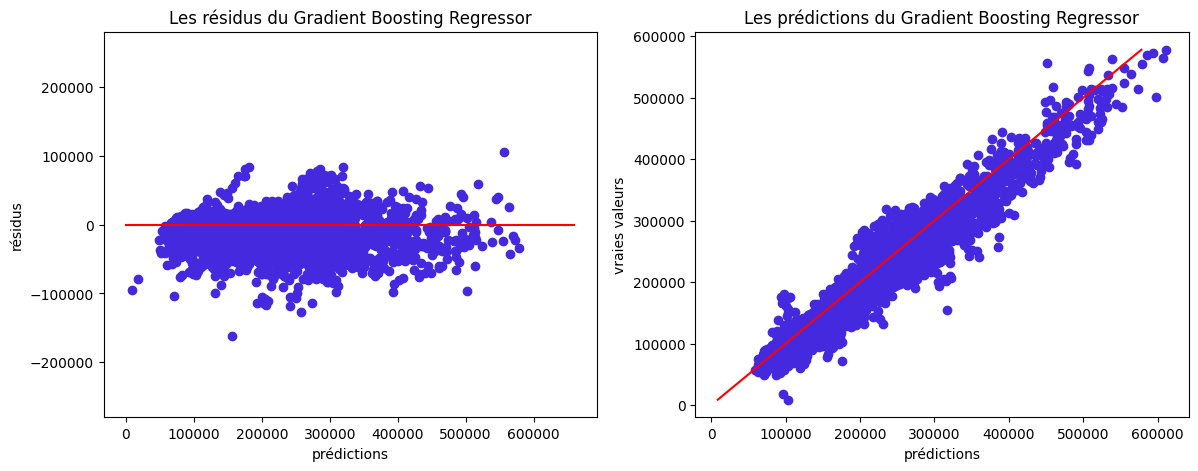

In [11]:
residus_g = y_test - pred_g
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.scatter(y_test, residus_g, color='#4529de')
plt.plot((0, 660000), (0, 0), color = 'red')
plt.xlabel("prédictions")
plt.ylabel("résidus")
plt.ylim([-280000,280000])
plt.title('Les résidus du Gradient Boosting Regressor')

plt.subplot(122)
plt.scatter(pred_g, y_test, color='#4529de')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), color = 'red')
plt.xlabel("prédictions")
plt.ylabel("vraies valeurs")
plt.title('Les prédictions du Gradient Boosting Regressor')
plt.show()

In [12]:
df['Prédictions'] = pred_g
df['Différence'] = y_test - pred_g
display(df)

,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Energies renouvelables (MW),Année,Mois,Jour,TMin (°C),TMax (°C),TMoy (°C),Prédictions,Différence
0,11,318695.5,516.5,0.0,11324.5,2022,6,1,7.84,22.58,15.21,314455.612445,4239.887555
1,11,313974.0,554.0,0.0,12427.0,2022,6,2,10.10,24.70,17.40,300358.928254,13615.071746
2,11,311511.0,1212.0,0.0,10975.0,2022,6,3,14.02,22.52,18.27,306633.362897,4877.637103
3,11,284531.0,512.5,0.0,11543.0,2022,6,4,15.36,28.88,22.12,308694.537942,-24163.537942
4,11,268396.5,551.5,0.0,11747.5,2022,6,5,15.72,22.62,19.17,299225.625838,-30829.125838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,93,176827.0,26750.5,0.0,59290.0,2023,9,26,11.45,27.02,19.23,184797.934929,-7970.934929
5780,93,174538.5,25334.0,0.0,52867.5,2023,9,27,12.28,27.47,19.88,188943.372543,-14404.872543
5781,93,177649.5,16756.5,0.0,55536.0,2023,9,28,13.80,26.60,20.20,184135.352079,-6485.852079
5782,93,179793.5,14472.0,0.0,53252.0,2023,9,29,13.98,28.32,21.15,184157.592247,-4364.092247


In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

gradboost = ['gradboost test', mean_absolute_error(y_test, pred_g), mean_squared_error(y_test, pred_g),
             np.sqrt(mean_squared_error(y_test, pred_g)), gbr.score(X_test,y_test)]
gradboost_t = ['gradboost train', mean_absolute_error(y_train, pred_g_train),
               mean_squared_error(y_train, pred_g_train), np.sqrt(mean_squared_error(y_train, pred_g_train)),
               gbr.score(X_train, y_train)]
tableau = [gradboost,gradboost_t]

dataF = pd.DataFrame(data=tableau, columns=['modèle','mae','mse','rmse','r²'])
display(dataF.set_index('modèle'))

,mae,mse,rmse,r²
modèle,,,,
gradboost test,17672.909691,5.867408e+08,24222.733043,0.926357
gradboost train,1832.242800,6.023580e+06,2454.298316,0.999407


# Des prédictions sans machine learning

In [14]:
df_nml = dfn

# Groupement par 'Code INSEE région', 'Mois', et 'Jour' en calculant la moyenne de 'Consommation (MW)'
dfm = df_nml.groupby(['Code INSEE région', 'Mois', 'Jour'])['Consommation (MW)'].mean().reset_index()

# Fusionner les DataFrames sur les colonnes communes
df_merged = pd.merge(df_nml, dfm, on=['Code INSEE région', 'Mois', 'Jour'], suffixes=('_original', '_mean'))

# Afficher le résultat
display(df_merged)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcul de l'erreur quadratique moyenne (MSE) par région
mse = mean_squared_error(df_merged['Consommation (MW)_original'], df_merged['Consommation (MW)_mean'])

# Calcul de l'erreur absolue moyenne (MAE) par région
mae = mean_absolute_error(df_merged['Consommation (MW)_original'], df_merged['Consommation (MW)_mean'])

# Calcul du coefficient de détermination (R²) par région
r2 = r2_score(df_merged['Consommation (MW)_original'], df_merged['Consommation (MW)_mean'])

# Affichage des résultats
print("MSE par région:", mse)
print("MAE par région:", mae)
print("R² par région:", r2)

,Code INSEE région,Consommation (MW)_original,Thermique (MW),Nucléaire (MW),Energies renouvelables (MW),Année,Mois,Jour,TMin (°C),TMax (°C),TMoy (°C),Consommation (MW)_mean
0,11,399184.0,14773.0,0.0,8000.0,2016,1,1,3.30,8.76,6.03,431108.714286
1,11,538676.0,24444.0,0.0,7829.0,2017,1,1,-4.62,0.66,-1.98,431108.714286
2,11,399523.0,14094.0,0.0,9459.0,2018,1,1,5.96,9.28,7.62,431108.714286
3,11,408620.0,19815.0,0.0,7940.0,2019,1,1,6.88,8.20,7.54,431108.714286
4,11,472417.0,15510.0,0.0,6814.0,2020,1,1,-1.42,5.42,2.00,431108.714286
...,...,...,...,...,...,...,...,...,...,...,...,...
28099,93,270539.0,8623.0,0.0,49250.0,2017,12,31,4.17,12.70,8.43,274328.833333
28100,93,277805.0,57815.0,0.0,47867.0,2018,12,31,2.40,12.60,7.50,274328.833333
28101,93,273760.0,59678.0,0.0,84519.0,2019,12,31,1.00,13.23,7.12,274328.833333
28102,93,305352.0,43063.0,0.0,40332.0,2020,12,31,-1.05,6.80,2.88,274328.833333


MSE par région: 480303359.5938132
MAE par région: 15829.597639041383
R² par région: 0.9526895637243609


Graphiques : interprétabilité des résultats

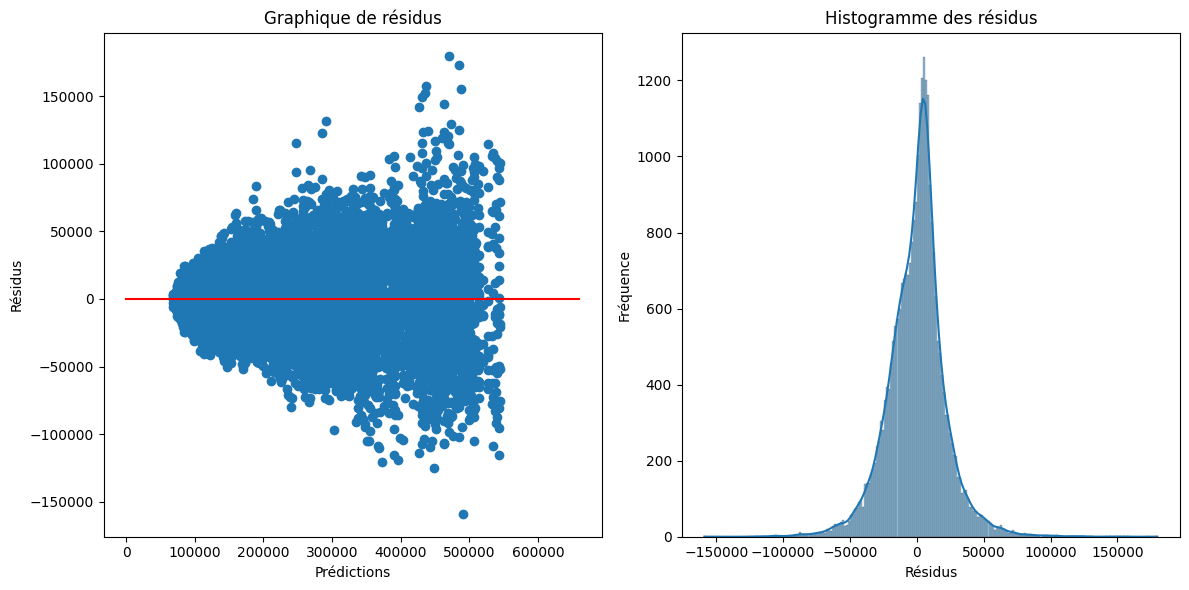

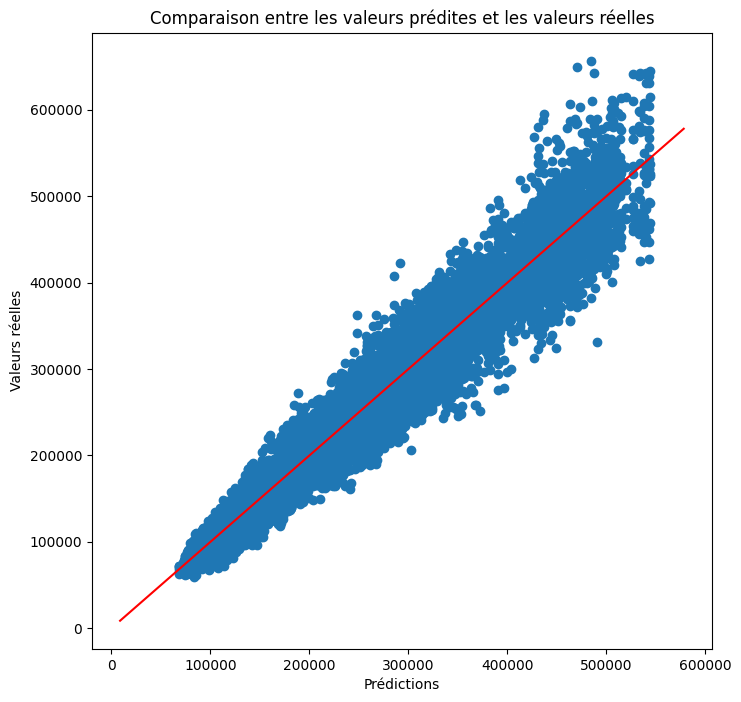

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot pour les résidus
residuals = df_merged['Consommation (MW)_original'] - df_merged['Consommation (MW)_mean']
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_merged['Consommation (MW)_mean'], residuals)
plt.plot((0, 660000), (0, 0), color = 'red')
plt.title('Graphique de résidus')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')

# Histogramme des résidus
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

# Scatter plot pour les valeurs prédites et les valeurs réelles
plt.figure(figsize=(8, 8))
plt.scatter(df_merged['Consommation (MW)_mean'], df_merged['Consommation (MW)_original'])
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), color = 'red')
plt.title('Comparaison entre les valeurs prédites et les valeurs réelles')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()